In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit,vmap
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [2]:
means = np.array([-.3,2,3])
sigmas = np.array([1,2.5,.7])
ps = np.array([.2,.5,.3])
def gmm_samples(N):
    c = 2
    i = np.random.choice(len(means),N,p=ps)
    z = np.random.randn(N)
    return z*sigmas[i]+means[i]

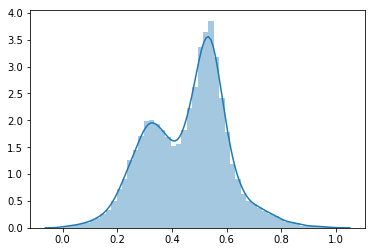

In [3]:
x = gmm_samples(20000)
x = (x+5)/15
x=x[(x<1)&(x>0)]
sns.distplot(x)

In [165]:
default_bits=12
@jit
def data2bits(val,prec=default_bits):
    """ returns the sequence of bits for a number up to 2^(-num_bits) precision (between 0 and 1)"""
    labels = []
    for i in range(prec):
        labels.append((val>.5).astype(np.int32))
        val = 2*(val-(val>.5)*.5)
    return jnp.array(labels)

@jit
def bits2samples(bits):
    val = 0.
    for i,b in enumerate(bits):
        val += b/2**(i+1)
    val += np.random.rand()/2**(len(bits)+1)
    return val

In [166]:
# b = vmap(data2bits)(x)
# sns.distplot(x)
# sns.distplot(vmap(bits2samples)(b))

In [191]:
def sample_data(N):
    z = gmm_samples(N)
    z = (z+5)/15
    z=z[(z<1)&(z>0)]
    return z
z =sample_data(1000)
dataset = vmap(data2bits)(z)
dataset = torch.from_numpy(np.asarray(dataset))
ds =torch.cat([2*torch.ones(dataset.shape[0],1,device=dataset.device,dtype=dataset.dtype),dataset],dim=1).long()

In [192]:
import torch.nn as nn
import torch.nn.functional as F

class GRUautoregressor(nn.Module):
    def __init__(self,classes,hidden_units):
        super().__init__()
        self.classes=classes
        self.in_embedding = nn.Embedding(classes+1,hidden_units)
        self.gru = nn.GRU(hidden_units,hidden_units,batch_first=True)
        self.out_embedding = nn.Linear(hidden_units,classes+1)
        self.k = hidden_units
    def forward(self,X,h0=None):
        """ [X (bs,N)], [h0 (bs,k)] -> [X_logp (bs,N,classes)] """
        if h0 is None: h0 = torch.zeros(X.shape[0],self.k,device=X.device)
        out = self.in_embedding(X)
        Y,hf = self.gru(out,h0[None])
        X_out_logits = self.out_embedding(Y)
        X_logp = F.log_softmax(X_out_logits,dim=-1)
        return X_logp
    def sample(self,bs):
        X = [2*torch.ones(bs).long()]
        hi = torch.zeros(bs,self.k)
        for i in range(default_bits):
            inn = self.in_embedding(X[-1])
            Y, hi = self.gru(inn.unsqueeze(1),hi.unsqueeze(0))
            hi = hi.squeeze(0)
            Xprobs = F.softmax(self.out_embedding(Y.squeeze(1))[:,:-1],dim=-1) #(bs,C-1) #exclude stop token
            dist = torch.distributions.categorical.Categorical(Xprobs)
            X.append(dist.sample())
        return torch.stack(X[1:],dim=1)
    
    def density(self):
        bs = 2**default_bits
        all_seqs = vmap(data2bits)(np.arange(bs)/bs)
        all_seqs = torch.from_numpy(np.asarray(all_seqs)).long()
        all_seqs0 = torch.cat([2*torch.ones(all_seqs.shape[0],1,device=all_seqs.device,dtype=all_seqs.dtype),all_seqs],dim=1)
        
        logps = self.forward(all_seqs0)[:,:-1,:-1][np.arange(bs)[:,None],np.arange(default_bits)[None],all_seqs] #(bs,N)
        ps = logps.sum(1).exp()
        return ps*2**default_bits
        
            
    
def loss(model,seq):
    target = torch.roll(seq,-1,1)
    pred_logp = model(seq) #(bs,N,classes)
    return F.nll_loss(pred_logp.reshape(-1,pred_logp.shape[-1]),target.reshape(-1))


def batches(ds,bs):
    ids = np.random.permutation(len(ds))
    count = 0
    while count<len(ds):
        yield ds[ids[count:count+bs]]
        count+=bs

In [197]:
model = GRUautoregressor(2,64)
optim = torch.optim.AdamW(model.parameters(), lr=3e-3,weight_decay=1e-2)

samples = []
losses = []
for epoch in tqdm(range(100)):
    for i, x in enumerate(batches(ds,bs=50)):
        optim.zero_grad()
        L = loss(model,x)
        L.backward()
        optim.step()
    losses.append(L)
    if not epoch%10:
        samples.append(vmap(bits2samples)(model.sample(10000).data.numpy()))
    

/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [194]:
#plt.plot(np.arange(2**default_bits)/2**default_bits,2**default_bits*model.density().data.numpy())

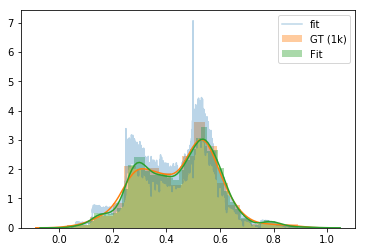

In [198]:
prec=5

#plt.hist(z,bins=np.arange(2**prec)/2**prec,label='Binned',density=True,color='purple',alpha=.3)
plt.plot(np.arange(2**default_bits)/2**default_bits,model.density().data.numpy(),label='fit',alpha=.3)
#sns.distplot(z,label='Train Data (1k)')
sns.distplot(z,label='GT (1k)')

sns.distplot(samples[-1],label='Fit')

plt.legend()

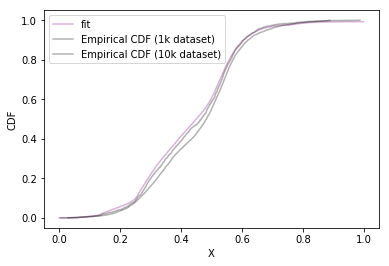

In [199]:
prec=5

#plt.hist(z,bins=np.arange(2**prec)/2**prec,label='Binned',density=True,color='purple',alpha=.3)
plt.plot(np.arange(2**default_bits)/2**default_bits,np.cumsum(model.density().data.numpy())/2**default_bits,label='fit',alpha=.3,color='purple')
#sns.distplot(z,label='Train Data (1k)')
sorted_z = np.sort(z)
plt.plot(sorted_z,(np.arange(len(z))+.5)/len(z),label='Empirical CDF (1k dataset)',alpha=.3,color='k')
z2 = sample_data(10000)
sorted_z2 = np.sort(z2)
plt.plot(sorted_z2,(np.arange(len(z2))+.5)/len(z2),label='Empirical CDF (10k dataset)',alpha=.3,color='k')
plt.xlabel('X')
plt.ylabel('CDF')

#sns.distplot(samples[-1],label='Fit')

plt.legend()

In [35]:
p = torch.tensor([[.5,.3],[.1,.8],[.3,.6]])

In [36]:
p.shape

torch.Size([3, 2])

In [37]:
d = torch.distributions.categorical.Categorical(p)

In [38]:
d.sample((10,)).shape

torch.Size([10, 3])

In [45]:
d.sample()

tensor([0, 0, 0])